# Sequence-to-Sequence: Language Translation

In this assignment you will use a database of pairs of (English,French) sentences to train an RNN model to translate from English to French.

The directory ../resource/asnlib/publicdata contains two files, "small_vocab_en.txt" and "small_vocab_fr.txt". Line "n" of the first file corresponds to line "n" of the second file.

Also see data here: http://www.statmt.org/wmt14/translation-task.html

Keras resources:
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
* https://stackoverflow.com/questions/38714959/understanding-keras-lstms/50235563#50235563

Neural Language Translation Resources:
* https://arxiv.org/abs/1703.01619
* https://www.tensorflow.org/tutorials/seq2seq

# Setup
## Imports

In [ ]:
import math
import os
import string

import matplotlib.pyplot as plt

from IPython.display import SVG

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout, Embedding, Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

## Configure Tensorflow to be less aggressive about RAM utilization when it starts up

In [ ]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [ ]:
TRAIN_TEST_SPLIT = 0.7           # % of data in training set

NUM_LSTM_NODES = 256             # Num of intermediate LSTM nodes
CONTEXT_VECTOR_SIZE = 256        # Size of context vector (num of LSTM nodes in final LSTM layer)

EMBEDDING_DIM = 100              # Embedding layer size for input words

BATCH_SIZE = 64
NUM_EPOCHS = 500

NUM_DATA_EXAMPLES = 5000         # limit memory usage while experimenting

LR = 0.01
DROPOUT = 0.3

# Text Preprocessing
These are provided so you can focus on the neural net modeling.

In [ ]:
# A useful string full of characters to remove
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def add_space_around_punctuation(s):
    result = ''
    for c in s:
        if c in string.punctuation and c != "'":  # Apostrophes are important
            result += ' %s ' % c
        else:
            result += c
    return result

def clean_sentence(s):
    s = s.strip()
    s = s.lower()
    s = add_space_around_punctuation(s)
    return s

### Functions to get words from sentences

In [ ]:
def get_words_from_sentence(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    words = list(filter(None, s.split(' ')))
    if reverse:
        words = words[::-1]
    if add_start_symbol:
        words = ['<S>'] + words
    if add_end_symbol:
        words.append('</S>')
    return words

def get_word_list_from_sentence_string(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    return get_words_from_sentence(clean_sentence(s), add_start_symbol, add_end_symbol, reverse)

def get_sentences(path, filename, add_start_symbol=False, add_end_symbol=False, reverse=False):
    with open(os.path.join(path, filename), 'r') as f:
        lines = f.readlines()
        return [get_word_list_from_sentence_string(s, add_start_symbol, add_end_symbol, reverse)
                for s in lines]

def get_word_set(sentences):
    words = set()
    for s in sentences:
        for word in s:
            words.add(word)
    return words

## Read the data and build useful data structures, such as a list of sentences and lists of words.

In [ ]:
# Store the input sentences (English) in s1
# Store the target senteces (French) in s2

# Consider reversing the input sentences to improve trianing.
# Add start and stop symbols for the decoder.
PATH = '../content'
s1 = get_sentences(PATH, 'small_vocab_en.txt', True, True, True)
s2 = get_sentences(PATH, 'small_vocab_fr.txt', True, True, True)

In [ ]:
# Restruct to a subset of the data
s1 = s1[:NUM_DATA_EXAMPLES]
s2 = s2[:NUM_DATA_EXAMPLES]

In [ ]:
# Show a sample sentence pair.
' '.join(s1[0]), ' '.join(s2[0])

('<S> . april in snowy is it and , autumn during quiet sometimes is jersey new </S>',
 "<S> . avril en neigeux est il et , automne l' pendant calme parfois est jersey new </S>")

In [ ]:
# Create two lists, w1 and w2, which hold the set of all words that show up in s1 and s2.
w1 = get_word_set(s1)
w2 = get_word_set(s2)

### Utilities for mapping words to integers

In [ ]:
def get_word_to_index_dict(words):
    return {w: i+1 for i,w in enumerate(words)}  # use i+1 to reserve 0 for the mask index
def reverse_dict(d):
    return {v: k for k,v in d.items()}

In [ ]:
word_to_index1 = get_word_to_index_dict(w1)
word_to_index2 = get_word_to_index_dict(w2)
index_to_word1 = reverse_dict(word_to_index1)
index_to_word2 = reverse_dict(word_to_index2)
index_to_word1[0] = '<MASK>'
index_to_word2[0] = '<MASK>'

In [ ]:
def sentence_to_indices(s, word_to_index):
    """Input s is a list of words. word_to_index is a dict mapping words to indices.
    Note: originally this said "s was a string"

    This function should convert a sentence to a list of indices, such as [5, 2, 17, 3], and return the list."""
    indices = [word_to_index[word] for word in s]
    return indices

In [ ]:
def indices_to_sentence(indices, index_to_word):
    """indices is a list of word indices. word_to_index is a dict mapping indices to words.

    This function should convert the indices list, such as [5, 2, 17, 3], to a list of word strings, and
    return the list."""
    indices = [index_to_word[x] for x in indices if x != 0]
    return indices

In [ ]:
# Test the functions.
x = sentence_to_indices(get_word_list_from_sentence_string('vous aimez raisins.', add_start_symbol=True), word_to_index2)
x

[275, 28, 195, 213, 72]

In [ ]:
indices_to_sentence(x, index_to_word2)

['<S>', 'vous', 'aimez', 'raisins', '.']

In [ ]:
# Record the number of words in the input and output data, respectively.
num_words_X = len(w1) + 1  # add 1 to reserve 0 for mask
num_words_y = len(w2) + 1  # add 1 to reserve 0 for mask
num_words_X, num_words_y

(199, 310)

In [ ]:
# Convert the input sentences in s1 to a list of sentences each represented as a list of integers.
# For example, the output list might look like [[5, 2, 17, 3], [1, 9, 85, 3, 22, 9], ...]
# Do the same for the output sentences.
inputs_as_indices = [sentence_to_indices(s, word_to_index1) for s in s1]
outputs_as_indices = [sentence_to_indices(s, word_to_index2) for s in s2]

In [ ]:
# Now pad the input and output index sequences with a filler (index 0) so that all sequences for each LSTM have the
# same length. Use the keras function pad_sequences to do this easily.
# Hint: For the inputs, padding should be on the left, like so: [[0, 0, 5, 2, 17, 3], ...]
#       For the outputs, padding should be on the right, like so: [[9, 7, 5, 4, 0, 0, 0], ...]
inputs = keras.utils.pad_sequences(inputs_as_indices, padding='pre') # based on inputs_as_indices
outputs = keras.utils.pad_sequences(outputs_as_indices, padding='post') # based on outputs_as_indices

In [ ]:
# compute the maximum sequence length of the inputs and outputs, just to see how they look.
max_seq_len_X = len(inputs[0])
max_seq_len_y = len(outputs[0])
max_seq_len_X, max_seq_len_y

(19, 24)

In [ ]:
# Just for convenience: define some more expressive variable names
max_input_seq_len = max_seq_len_X
max_output_seq_len = max_seq_len_y
num_input_words = num_words_X
num_output_words = num_words_y

In [ ]:
# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs,
                                                    test_size=1 - TRAIN_TEST_SPLIT,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3499, 19), (1501, 19), (3499, 24), (1501, 24))

In [ ]:
# We need to make a one-hot-encoded version of the outputs ourselves for use in the loss function.
# The inputs get this for free via use of Embedding layers in Keras.
#
# Hint: use the keras function to_categorical.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## Create Model

Now we need to write code to build the SeqToSeq model. **Important**: In Keras we have to use the "functional API" in order to access the LSTM internal state that we use as the "context vector" or "encoding" of a sentence. We also need to store hooks into the model to be able to run the translator on new sentences after training.

This code will create variables representing the entire SeqToSeq model (for use in training), as well as the individual encoder segment and decoder segment of the model, for use in inference.

### Encoder

We will implement the following architecture for the encoder section of the seq2se1 model:
    
1. Encoder input (encoder_inputs): Input layer, shape (max_seq_len_X,). For convenience, name the layer: name='encoder_input'
2. Masking layer (encoder_masking): doesn't change shape. Ignores leading mask value ("0"s) in short sequences.
3. Embedding layer (encoder_embedding): output shape (max_seq_len_X, EMBEDDING_DIM)
4. LSTM layer: size is NUM_LSTM_NODES. uses dropout at rate given by DROPOUT.

Hint: Be sure to set the "return_sequences" and "return_state" parameters appropriately in the LSTM for the encoder.

In [ ]:
# Build RNN model.

encoder_inputs = Input(shape=(max_seq_len_X,), name='encoder_input')

encoder_masking = Masking(mask_value=0.0, name='encoder_masking')(encoder_inputs)

encoder_embedding = Embedding(input_dim=num_input_words, output_dim=EMBEDDING_DIM, name='encoder_embedding')(encoder_masking)

encoder_outputs, state_h, state_c  = LSTM(NUM_LSTM_NODES, dropout=DROPOUT, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder_embedding)
#encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding) # Thought this might remove the warning
# Discard `encoder_outputs` and only keep the states. We don't use the outputs in the encoder.
# Recall that the LSTM has two states we have to keep track of: c and h.
encoder_states = [state_h, state_c]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_embedding' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


### Decoder

# The decoder should have the following architecture:
    
1. Decoder input (decoder_input): shape (None,)
2. Masking layer (decoder_masking), as above.
3. Embedding layer (decoder_embedding): output shape (max_seq_len_y, EMBEDDING_DIM)
4. LSTM layer (decoder_lstm), as above. However, keep a function around to easy recreate the LSTM layer later on, during generation.
6. Dense layer with softmax activation (decoder_output): output shape (num_output_words,)

Hint: Be sure to set the "return_sequences" and "return_state" parameters appropriately in the LSTM for the encoder.

In [ ]:
# Decoder section
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_inputs_masking = Masking(mask_value=0.0, name='decoder_masking')(decoder_inputs)
decoder_inputs_embedded = Embedding(input_dim=num_output_words, output_dim=EMBEDDING_DIM, name='decoder_embedding')(decoder_inputs_masking)
decoder_lstm = LSTM(NUM_LSTM_NODES, dropout=DROPOUT, return_sequences=True, return_state=True, name='decoder_lstm')  # N.B. Just define an LSTM here, but don't pass in the previous layer variable yet.

z, _, _ = decoder_lstm(decoder_inputs_embedded, initial_state=encoder_states)     # Pass in the context vector using the "initial_state" param

decoder_dense = Dense(num_output_words, activation='softmax', name='decoder_dense') # Like LSTM above: define function for later use
decoder_outputs = decoder_dense(z)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'decoder_embedding' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


### Put it all together into one model, and visualize

In [ ]:
# Define the complete seq2seq model.
# This will take encoder_input_data & decoder_input_data as inputs and learn to output the decoder_target_data.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 19)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_masking (Masking) │ (None, 19)             │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_masking (Masking) │ (None, None)           │              0 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 19, 100)        │         19,900 │ encoder_masking[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 100)      │         31,000 │ decoder_masking[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm_1 (LSTM)     │ [(None, 19, 256),      │        365,568 │ encoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 256),    │        365,568 │ decoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │ encoder_lstm_1[0][1],  │
│                           │ 256)]                  │                │ encoder_lstm_1[0][2]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 310)      │         79,670 │ decoder_lstm[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 861,706 (3.29 MB)

 Trainable params: 861,706 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

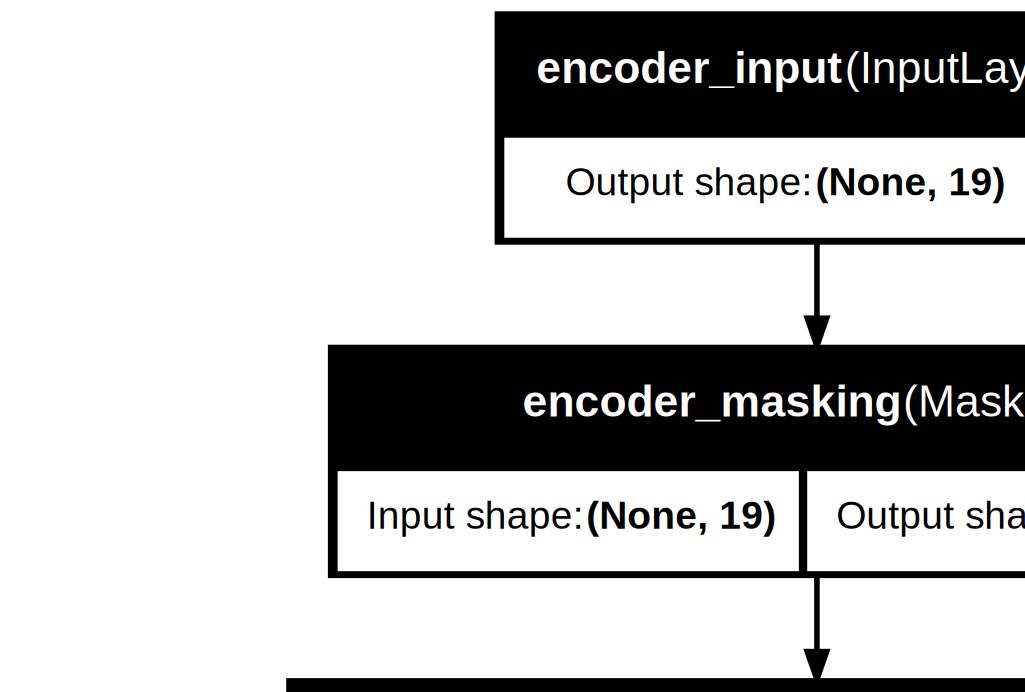

In [ ]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Prepare train/test data.

In [ ]:
encoder_input_data = X_train
decoder_input_data = y_train

In [ ]:
# decoder_target_data will be ahead by one timestep
# and will not include the start token.
decoder_target_data = np.zeros(y_train_one_hot.shape)
decoder_target_data[:,:-1] = y_train_one_hot[:,1:,:]

In [ ]:
decoder_target_data_test = np.zeros(y_test_one_hot.shape)
decoder_target_data_test[:,:-1] = y_test_one_hot[:,1:,:]

In [ ]:
optimizer = Adam(learning_rate=.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [ ]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto',
                                cooldown=0, min_lr=0)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
# Run training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=([X_test, y_test], decoder_target_data_test),
          callbacks=[lr_callback, early_stopping_callback])

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step - loss: 3.9256 - val_loss: 2.3619 - learning_rate: 0.0010
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - loss: 2.2467 - val_loss: 1.8054 - learning_rate: 0.0010
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 304ms/step - loss: 1.6632 - val_loss: 1.2643 - learning_rate: 0.0010
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - loss: 1.1791 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - loss: 0.9576 - val_loss: 0.8531 - learning_rate: 0.0010
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - loss: 0.8321 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - loss: 0.7719 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - loss: 0.7225 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - loss: 0.6909 - val_loss: 0.6762 - learning_rate:

# Inference

We have trained a model, but how do we use it to actually translate sentences? We have to do more work ourselves here than with a non-recurrent neural net, so we'll write a function to help out. Here are the steps:

1. **Encode**:
    1. Run the entire input sentence through the encoder part of the model.
    1. Write down the "context vector" -- this is the state of the last LSTM encoder layer.<br><br>

2. **Decode in a loop**:
    1. Seed the decoder LSTM with the context vector.
    1. Run a *single step* of the decoder with the input "`<S>`" (the start symbol).
    1. Store the output. This is a word of the translation!
    1. Return to step 2B, but feed in the word from step 2C as the new input. Repeat until the decoder returns "`</S>`" (the end symbol).

In [ ]:
# Define a version of our model for use in sampling (as opposed to training).
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 19)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_masking (Masking)            │ (None, 19)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_embedding (Embedding)        │ (None, 19, 100)             │          19,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_lstm_1 (LSTM)                │ [(None, 19, 256), (None,    │         365,568 │
│                                      │ 256), (None, 256)]          │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385,468 (1.47 MB)

 Trainable params: 385,468 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

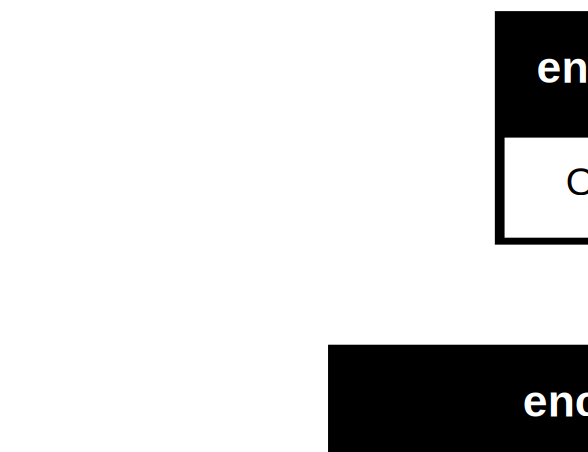

In [ ]:
SVG(model_to_dot(encoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# Build the decoder.
decoder_state_input_h = Input(shape=(NUM_LSTM_NODES,))
decoder_state_input_c = Input(shape=(NUM_LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_embedded, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_masking (Masking) │ (None, None)           │              0 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 100)      │         31,000 │ decoder_masking[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 256)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 256),    │        365,568 │ decoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │ input_layer[0][0],     │
│                           │ 256)]                  │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, None, 310)      │         79,670 │ decoder_lstm[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 476,238 (1.82 MB)

 Trainable params: 476,238 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

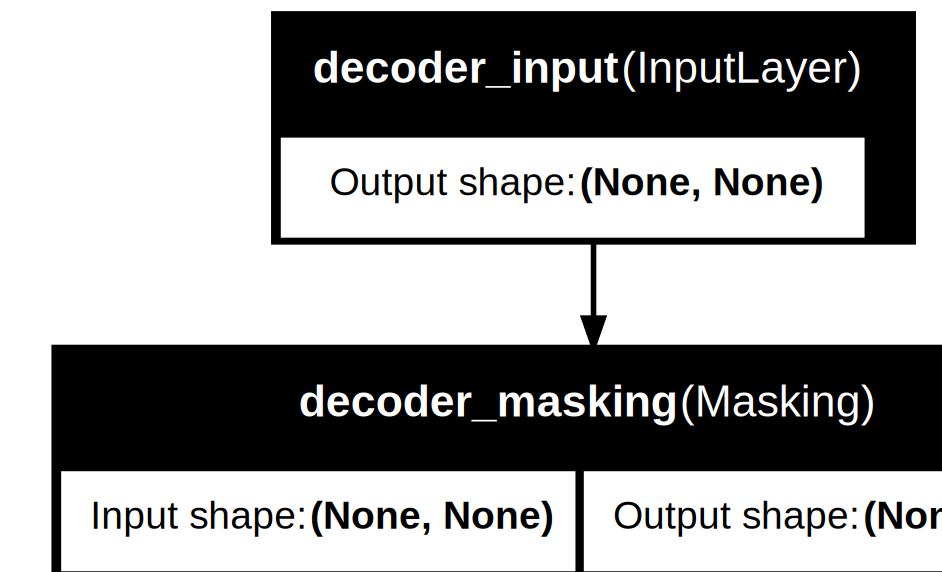

In [ ]:
SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
def translate_sequence(input_seq):
    # Encode the input as state vectors.
    # Use the encoder_model to get the h and c vectors.
    encoder_states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first word of target sequence with the start symbol '<S>'.
    target_seq[0, 0] = word_to_index2['<S>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    decoded_sentence = ''
    stop_condition = False
    step = 0
    while not stop_condition:
        # Use the decoder to get the output token vector and the h and c vectors
        output_tokens, h, c = decoder_model.predict([target_seq] + encoder_states_value)

        # Find the largest value in the probability output vector, and use that index as your output word
        # at this time step.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_to_word2[sampled_token_index]

        # Add the word to the output sentence string
        decoded_sentence += f' {sampled_word}'

        # Check for the stop condition: either hit max length or find the stop token '</S>'.
        # Stopping condition: either hit max length or find the stop token '</S>'.
        if sampled_word == '</S>' or step >= max_output_seq_len:
          stop_condition = True


        # Update the target sequence (of length 1).
        target_seq[0, 0] = sampled_token_index

        # Update states
        encoder_states_value = [h, c]
        step += 1

    return decoded_sentence

# Test your network: feed in 10 sentences and show the results.

In [ ]:
for i in range(10):
    # Print an input sentence
    # Translate it and print the output sentence
    input_seq = X_test[i:i+1]
    #print(f'Input: {i+1}: {input_seq}')
    input_sentence = indices_to_sentence(input_seq[0], index_to_word1)
    print(f"Input Sentence {i+1}: {' '.join(input_sentence)}")
    translated_sentence = translate_sequence(input_seq)
    print(f'Output Sentence: {i+1}: {translated_sentence}')

Input Sentence 1: <S> . orange the is loved most their but , banana the is fruit loved most my </S>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Output Sentence: 1:  . l'orange est aimé plus leur mais , banane la est aimé plus le fruit mon </S>
Input Sentence 2: <S> . strawberries and , oranges , apples likes she </S>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1

### Question: How well do you think the model did? Discuss any problems you ran into.

It did pretty ewll, reading it backwards is painful but that's an easy fix. I didn't test it on a random set so I may have missed some outputs, and also I don't know French (unfortunately, I want an August holiday).

# Evaluate model accuracy

### Compute the accuracy of the model on the test set.
In a detailed study we would calculate the "BLEU" score for the translation task.
For this assignment, we'll keep things simple. Just calculate an all-or-nothing accuracy score on each translated sentence. If all the words appear in the output, in the correct order, without extra words, the score on that example is 1. Otherwise 0. Compute the accuracy over all examples in the test set. You may ignore punctuation (commas) and `<S>` and `</S>` symbols.

In [ ]:
def remove_punctuation(s):
      s = ' '.join([word for word in s.split() if word not in ['<S>','</S>','<MASK>','<PAD>']])
      s = ''.join([char if char not in string.punctuation else '' for char in s])
      return s.lower()


def calculate_match_acc(X_test, y_test):
    correct = 0
    for i in range(len(X_test)//25):
        input_seq = X_test[i:i+1]
        translated_sentence = translate_sequence(input_seq)

        target_seq = y_test[i]
        target_seq = indices_to_sentence(target_seq, index_to_word2)
        target_seq = ' '.join(target_seq)
        #print(target_seq)
        #print(translated_sentence)
        translated_seq = remove_punctuation(translated_sentence)
        target_seq = remove_punctuation(target_seq)
        #print(translated_seq)
        #print(target_seq)

        if translated_seq == target_seq:
            correct += 1
    return correct / (len(X_test)//25)

## Report the accuracy value you obtained.

In [ ]:
print(len(X_test))
print(len(y_test))

1501
1501


In [ ]:
acc = calculate_match_acc(X_test, y_test)
print(f'Accuracy: {acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

# Analysis

1. The numbers speak. The model is startlingly accurate at first glance but tends to fall apart as it goes along. It made me second guess if I made some large mistakes or was feeding it incorrectly, and should've been clearing states between sentences. I am overall impressed with the trnaslation ability of the RNN and everything that it's capable of doing. The representation is pretty straightforward encoder-decoder layers with an LSTM where we encode into a fixed length vector and decode the output vector and output the predicted sequence, in this case a sentence. The two models work in tandem.
2. The one thing that got me on this lab was that I'm on a business trip right now, and I'm pretty tired. I misinterpreted the stop symbol as '<5>' not an S, so my model would never translate and terminate properly. It would fail in many instances and would also run forever in the final test and use up all my memory before crashing completely. When I looked at it with fresh eyes, I realized I had misinterpreted the symbol for some reason.
3. Another issue is the amount of memory it takes to continue validating -- really shows how intensive it can get (there's probably a ton of optimizations jthat can be done). I had to shorten the run to 15-20% of the test data because of how intensive it got (my laptop would overheat and use all 32gb of memory).

In [ ]:
%%shell

jupyter nbconvert --to html /content/SeqToSeq_BradleyBullman.ipynb

[NbConvertApp] Converting notebook /content/SeqToSeq_BradleyBullman.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 633786 bytes to /content/SeqToSeq_BradleyBullman.html
